<a href="https://colab.research.google.com/github/gavin-bauer/recode-core-ml-from-scratch/blob/master/log-reg-img-clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recoding a Logistic Regression Image Classifier

#### Synopsis
In order to understand the details of the most frequent algorithms in Machine Learning, I have recoded the core concepts in Python using only Numpy (for computations) and Matplotlib (for visualizations).

#### In this post
I re-implement the main components of a logistic regression image classifier.

#### NB
It is recommended that the reader is familiar with fundamental machine learning concepts such as _features_, _target_, _parameters_, _learning rate_, etc...

## Goal
Build a logistic regression classifier to recognize cats.

1. Upload the dataset containing square colored images labeled as cat (y=1) or non-cat (y=0).

2. Apply some preprocessing (reshaping and feature scaling) to the dataset.

3. Initialize the model's parameters (weights and bias)

4. Pass the data into the algorithm.
    - Learn the parameters for the model by minimizing the cost  

5. The algorithm outputs a value between 0 and 1, which should be treated as the estimated probability that $y = 1$ on input x, which can be written as:

     $h_\theta(x) = P(y=1 | x ; \theta)$

**The steps can be better visualized in the image below**

<img src="https://github.com/Kulbear/deep-learning-coursera/blob/master/Neural%20Networks%20and%20Deep%20Learning/images/LogReg_kiank.png?raw=1" style="width:650px;height:400px;">
<figcaption>Credits: Coursera</figcaption>

## 1 - Mount Gdrive & import packages

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2

%matplotlib inline

## 2 - Helper functions

In [0]:
def load_dataset():
    """
    Load the cat vs. non cat train and test sets.

    Return:
    x_train_raw -- An array representing an image
    y_train_raw -- An array representing the labels
    x_test_raw -- An array representing an image
    y_test_raw -- An array representing the labels
    classes -- An array containing the classes
    """

    train_dataset = h5py.File('drive/My Drive/datasets/train_catvnoncat.h5', "r")
    x_train_raw = np.array(train_dataset["train_set_x"][:])
    y_train_raw = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('drive/My Drive/datasets/test_catvnoncat.h5', "r")
    x_test_raw = np.array(test_dataset["test_set_x"][:])
    y_test_raw = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    y_train_raw = y_train_raw.reshape((1, y_train_raw.shape[0]))
    y_test_raw = y_test_raw.reshape((1, y_test_raw.shape[0]))
    
    return x_train_raw, y_train_raw, x_test_raw, y_test_raw, classes

In [0]:
def plot_image(x, y, classes, index):
    """
    Plot an image of the dataset. 

    Arguments:
    x -- A numpy array representing pixel values
    y -- A numpy array representing the labels
    classes -- An array containing the classes
    index -- An integer representing the index of an image

    Return:
    Plot of an image
    """
    
    print("y = " + str(y[:,index]) + ", it's a '" + classes[np.squeeze(y[:,index])].decode("utf-8") +  "' picture.")
    plt.imshow(x[index])
    plt.show()

In [0]:
def image2vector(x_train_raw, y_train, x_test_raw, y_test, verbose=False):
    """
    Reshape images and perform feature scaling on the datasets

    1. Reshape images of shape (width, height, channels) in a flatten numpy-array 
    of shape (width ∗ height ∗ channels, 1).
        - After this, x_train_raw and x_test_raw will be numpy-arrays where each 
        column represents a flattened image. 
        - In other words, the goal is to flatten a matrix of shape (a,b,c,d) 
        to a matrix of shape (b∗c∗d, a).

    2. Feature scaling by dividing every row by 255.
        - Each value in a vector corresponds to a pixel value ranging from 0 to 255, 
        representing one the color channels (red, green or blue). 
        - To avoid the gradients from exploding during backpropagation, 
        features will be scaled (meaning each features will have a similar range).

    Arguments:
    x_train_raw -- A numpy array representing pixel values
    y_train -- A numpy array representing the labels
    x_test_raw -- A numpy array representing pixel values
    y_test -- A numpy array representing the labels
    verbose -- If "True", prints the datasets' shapes

    Return:
    x_train -- a flatten numpy-array with scaled values
    x_test -- a flatten numpy-array with scaled values
    """

    # Check the datasets' shapes
    if verbose:
        print("Before preprocessing")
        print("x_train_raw shape: " + str(x_train_raw.shape))
        print("y_train shape: " + str(y_train.shape))
        print("x_test_raw shape: " + str(x_test_raw.shape))
        print("y_test shape: " + str(y_test.shape))

    # Reshape the feature matrices
    x_train_flatten = x_train_raw.reshape(x_train_raw.shape[0], -1).T
    x_test_flatten = x_test_raw.reshape(x_test_raw.shape[0], -1).T

    # Feature scaling
    x_train = x_train_flatten / 255.
    x_test = x_test_flatten / 255.

    if verbose:
        print("- - - - - " * 5)
        print("After preprocessing")
        print("x_train shape: " + str(x_train.shape))
        print("x_test shape: " + str(x_test.shape))

    return x_train, x_test

In [0]:
def plot_learning_curve(costs):
    costs = np.squeeze(costs)
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.show()

In [0]:
def plot_incorrect_preds(test_predictions, y_test):
    c = np.where(np.equal(test_predictions, y_test) < 1.)[1]

    plt.figure(figsize=(8,8))

    for i in range(9):

        actual = classes[int(y_test[0, c[i]])].decode("utf-8")
        pred = classes[int(test_predictions[0, c[i]])].decode("utf-8")

        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_test[:,c[i]].reshape((64, 64, 3)))
        plt.xlabel(f"pred: {pred} | actual: {actual}")

    plt.show()

## 3 - Load, explore and preprocess the dataset

Each line of train_set_x_raw and test_set_x_raw is an array representing an image.

In [0]:
# Load the dataset
x_train_raw, y_train, x_test_raw, y_test, classes = load_dataset()

y = [1], it's a 'cat' picture.


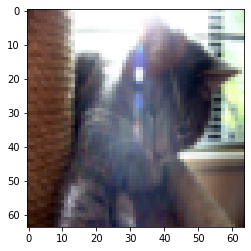

In [0]:
# Example of a picture
plot_image(x_train_raw, y_train, classes, index=42)

In [0]:
x_train, x_test = image2vector(x_train_raw, y_train, x_test_raw, y_test, verbose=True)

Before preprocessing
x_train_raw shape: (209, 64, 64, 3)
y_train shape: (1, 209)
x_test_raw shape: (50, 64, 64, 3)
y_test shape: (1, 50)
- - - - - - - - - - - - - - - - - - - - - - - - - 
After preprocessing
x_train shape: (12288, 209)
x_test shape: (12288, 50)


## 4 - Build the model's components 

The main steps for building a logistic regression algorithm are:

1. Define the model's representation

2. Initialize the model's parameters

3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

#### 4.1. Define the model's representation

In the case of a classification problem, the hypothesis model, for one example ($x^{(i)}$), can be  mathematically represented by: $\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})$, where:

* $z^{(i)} = w^T x^{(i)} + b$
* $w$ is a parameter vector, initialized with zeros
* $b$ is a scalar, initialized with a zero
* $x$ is a feature vector, with $x_0$ always equal to 1

In [0]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1 / (1 + np.exp(-z))
    
    return s

#### 4.2. Zero-initialize the parameters

In [0]:
def initialize_with_zeros(dim):
    """
    Create a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros(shape=(dim, 1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

### 4.3 - Loop: forward and backward propagation and update parameters

Implement the "forward" and "backward" propagation steps for learning the parameters.

#### 4.3.1 Forward Propagation

After initializing the parameters, the actual output of the model is calculated as follow: 

$$A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$$

The performance of the model is then evaluated using the following cost function:

$$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$$

In [0]:
def forward_propagation(w, b, X, Y):
    """
    Implement the forward propagation 

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    A -- predictions
    cost -- negative log-likelihood cost for logistic regression
    """

    A = sigmoid(np.dot(w.T, X) + b)
    cost = -np.average(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    return A, cost

####4.3.2 Back propagation: 

Finetune the parameters by computing the gradient of the loss function with respect to the parameters.

Mathematically, this is expressed as:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$

$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [0]:
def backward_propagation(w, b, X, Y, A):
    """
    Implement the backward propagation 

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    m = X.shape[1]

    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = np.average(A - Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)

    grads = {"dw": dw,
             "db": db}

    return grads

#### 4.3.3 The optimization function. 

In order to find the best parameters that minize the cost function, the parameters will be updated iteratively using an algorithm called "Gradient Descent".

For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [0]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve
    """

    costs = []
    iterations = []

    for i in range(num_iterations):
        A, cost = forward_propagation(w, b, X, Y)
        grads = backward_propagation(w, b, X, Y, A)
        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate * dw
        b = b - learning_rate * db

        if i % 100 == 0:
            costs.append(cost)
            iterations.append(i)

        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost}")

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs, iterations

In [0]:
def fit(X, Y):
    w, b = initialize_with_zeros(X.shape[0])
    params, grads, costs, iterations = optimize(w, b, X, Y, num_iterations=2000, 
                                    learning_rate=0.009, print_cost=False)
    return params, grads, costs, iterations

In [0]:
params, grads, costs, iterations = fit(x_train, y_train)

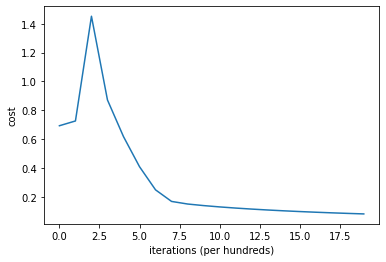

In [0]:
plot_learning_curve(costs)

## 5 - Predictions

Using the learned parameters, it is possible to predict the labels for a dataset X. The predictions will be denoted $\hat{Y}$, where $\hat{Y} = A = \sigma(w^T X + b)$

The algorithm outputs a value between 0 and 1, which should be treated as the estimated probability that $y = 1$ on input x, which can be written as:

$$A = P(y=1 | x ; \theta)$$

By setting a threshold at 0.5, it would be possible to declare that:
* if A <= 0.5, the entry falls into 0 (a non-cat image)
* if A > 0.5, the entry falls into 1 (a cat image)

In [0]:
def predict(params, X):
    m = X.shape[1]
    predictions = np.zeros((1, m))

    w = params["w"]
    b = params["b"]

    w = w.reshape(X.shape[0], 1)
    y_hat = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(y_hat.shape[1]):
        predictions[0, i] = 1 if y_hat[0, i] > 0.5 else 0
    
    assert(predictions.shape == (1, m))
    
    return predictions

In [0]:
train_predictions = predict(params, x_train)
test_predictions = predict(params, x_test)

train_acc = 100 - np.mean(np.abs(train_predictions - y_train)) * 100
test_acc = 100 - np.mean(np.abs(test_predictions - y_test)) * 100

print(f"train accuracy: {train_acc} %")
print(f"test accuracy: {test_acc} %")

train accuracy: 99.52153110047847 %
test accuracy: 70.0 %


**Comment**: 
* Training accuracy is ~100% meaning the model is working and has high enough capacity to fit the training data. 
* Test error is ~70% which not bad given the small dataset used and that logistic regression is a linear classifier.
* On the downside, the model is clearly overfitting the training data.

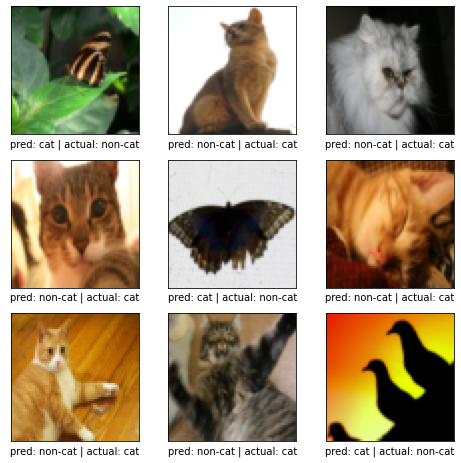

In [0]:
# Examples of pictures wrongly classified
plot_incorrect_preds(test_predictions, y_test)

## 6 - Test algorithm on a picture taken from Google

y = 1.0, the image is a "cat" picture.


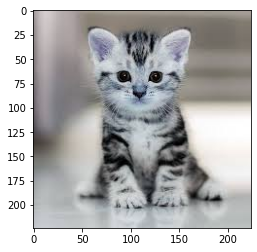

In [0]:
my_image = "drive/My Drive/datasets/kitten.jpg"
image = cv2.imread(my_image)
my_image = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC).reshape((1, 64 * 64 * 3)).T
my_predicted_image = predict(params, my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", the image is a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")